In [1]:
# Requires xarray_sentinel environment

import os
import glob
import pyproj
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import xarray as xr
import xarray_sentinel
import drama.utils as drtls
import s1sea.geo_plot as gplt
from s1sea.cmod5n import cmod5n_inverse
from s1sea.get_era5 import getera5
from s1sea.s1_preprocess import grd_to_nrcs, nrcs_to_roughness
from drama.performance.sar.antenna_patterns import sinc_bp

In [2]:
# importing from one directory  up
import sys 
sys.path.insert(0, "../" )

from misc import round_to_hour

In [3]:
# TODO perform analysis (averaging) along axis to see whether noise is present since no denoising is performed

data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
resolution_spatial = 100 # m

In [4]:
# NOTE Denoising is not performed

files = glob.glob(f"{data_dir}*")
NRCS = grd_to_nrcs(files[0], prod_res=resolution_spatial,  denoise=True)

/Users/opodriscoll/Documents/Scripts/s1sea/s1sea/s1_preprocess.py:57: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  calibration_vv = xr.open_dataset(path,
/Users/opodriscoll/Documents/Scripts/s1sea/s1sea/s1_preprocess.py:60: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constru

Calibrate VV
Denoising VV


/Users/opodriscoll/Documents/Scripts/s1sea/s1sea/s1_preprocess.py:85: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dd_vh = xr.open_dataset(path, engine="sentinel-1", group='IW/VH')
/Users/opodriscoll/Documents/Scripts/s1sea/s1sea/s1_preprocess.py:88: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the Da

Calibrate VH
Denoising VH


/Users/opodriscoll/Documents/Scripts/s1sea/s1sea/s1_preprocess.py:13: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  gcps = xr.open_dataset(path, engine="sentinel-1", group='IW/VV/gcp')
/Users/opodriscoll/Documents/Scripts/s1sea/s1sea/s1_preprocess.py:14: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the

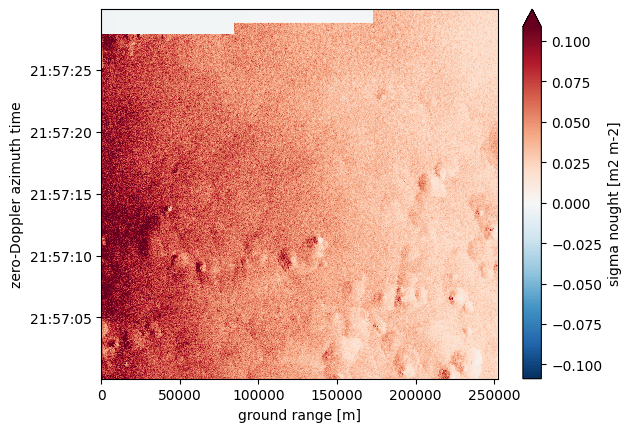

In [5]:
NRCS.NRCS_VV.plot(robust=True)

In [6]:
# Select date and location to querry ERA5
date = NRCS.azimuth_time.min().values.astype('datetime64[m]').astype(object)
date_rounded = round_to_hour(date)

yy, mm, dd, hh = date_rounded.year, date_rounded.month, date_rounded.day, date_rounded.hour
latmin = latmax = NRCS.latitude.mean().data*1
lonmin = lonmax = NRCS.longitude.mean().data*1

getera5(latmin, latmax, lonmin, lonmax, yy, mm, dd, hh, path=None, retrieve=True)

2023-11-10 17:28:34,055 INFO Welcome to the CDS
2023-11-10 17:28:34,057 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-10 17:28:34,362 INFO Request is completed
2023-11-10 17:28:34,363 INFO Downloading https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data0/adaptor.mars.internal-1699623188.0800297-10867-10-e0387914-7c28-4c64-9595-84227c48e12a.nc to era520201110.nc (1.3K)
2023-11-10 17:28:35,055 INFO Download rate 1.9K/s


'era520201110.nc'

In [7]:
# Compute wind speed and direction from ERA5
era5 = xr.open_dataset('era520201110.nc')
u10, v10 = np.ravel(era5.u10.values*1)[0], np.ravel(era5.v10.values*1)[0]
wdir_era5 = np.rad2deg(np.arctan2(u10, v10))

In [8]:
# Compute orientation of observation
lats, lons = NRCS.latitude.values, NRCS.longitude.values
geodesic = pyproj.Geod(ellps='WGS84')
ground_dir, _, _ = geodesic.inv(lons[0, 0], lats[0, 0], lons[-1,0], lats[-1,0])

In [9]:
# compute directional difference between satelite and era5 wind direction

def normalize_angle(angle):
    """
    Normalize the angle to be between -180 and 180 degrees.
    """
    return (angle + 180) % 360 - 180

def angular_difference(a, b):
    """
    Calculate the angular difference between angles a and b.
    """
    normalized_a = normalize_angle(a + 90)  # add 90 degrees as radar is right looking
    normalized_b = normalize_angle(b + 180) # add 180 degrees to go from blowing towards, to blowing from

    # Calculate the angular difference
    diff = (normalized_b - normalized_a + 180) % 360 - 180

    return diff

wdir_wrt_sensor = angular_difference(ground_dir, wdir_era5)

In [10]:
f0 = 5.3E9
x0 = 0
z0 = 700E3
c = 3E8
length_antenna = 3.2
height_antenna = 0.3
incidence_angle = 48
vx_sat = 6800 
PRF = 0.5
stride = vx_sat / PRF
neighbours = 1000

grg, az = np.meshgrid(np.arange(NRCS.latitude.data.shape[1]), np.arange(NRCS.latitude.data.shape[0])) # * resolution_spatial
grg_offset = np.tan(np.deg2rad(incidence_angle)) * z0
grg = np.arange(NRCS.latitude.data.shape[1]) * resolution_spatial + grg_offset
az = np.arange(NRCS.latitude.data.shape[0]) * resolution_spatial

data = xr.Dataset(
    data_vars=dict(
        nrcs = (["az", "grg"], NRCS.NRCS_VV.data, {'units': 'm2/m2'}),
        inc = (["az", "grg"], NRCS.inc.data, {'units': 'Degrees'}),
    ),
    coords=dict(
        az = (["az"], az, {'units': 'm'}),
        grg = (["grg"], grg, {'units': 'm'}),
    ),
    attrs=dict(wdir_wrt_sensor=wdir_wrt_sensor),
)

windfield = cmod5n_inverse(data.nrcs.values, data.wdir_wrt_sensor, data.inc.values)
data['windfield'] = (["az", "grg"], windfield, {'units': 'm/s'})

In [12]:
x = np.arange(x0, data.az.max().values*1 + stride, stride) 
data['x_sat'] = ('time_slow', x)
data['nrcs_weight'] = (data.nrcs / data.nrcs.mean()) # NOTE weight is linearly scaled with relative nrcs (e.g. local nrcs of twice the average will yield weight of 2.0)
data['distance_ground'] = np.sqrt((- data.x_sat + data.az )**2 + data.grg**2)
data['distance_slant_range'] = np.sqrt(data['distance_ground']**2 + z0**2)
data['angle_wrt_boresight'] = np.arctan((- data.x_sat + data.az )/data['distance_slant_range']) # incidence from boresight
data['incidence_wrt_boresight'] = np.arctan(data['distance_slant_range']/z0) - np.deg2rad(incidence_angle)
data['beam_grg'] = (['time_slow', 'az', 'grg'], sinc_bp(np.sin(data['angle_wrt_boresight']), L=length_antenna, f0=f0))
data['beam_az'] = (['time_slow', 'az', 'grg'], sinc_bp(np.sin(data['incidence_wrt_boresight']), L=height_antenna, f0=f0))
data['beam'] = data['beam_grg']*data['beam_az']

In [ ]:
# --------------------
# TODO compute wind how the backscatter field would be observed from a scatterometer








# --------------------

In [13]:
top_row = np.abs(data.beam.sum(dim='grg')).argmax(axis=1).values
top_row

masks = []
for i in top_row:
    mask = np.zeros_like(data.az)  # create a mask
    mask[i-neighbours:i+neighbours+1] = 1
    masks.append(mask)

temp = xr.Dataset(
    data_vars=dict(
        temp1 = (["az","time_slow"], np.array(masks).T), 
        temp2 = (["grg"], np.ones_like(data.grg))

    ),
    coords=dict(
        az=(["az"], data.az.values),
        grg=(["grg"], data.grg.values),
        time_slow=(["time_slow"], data.time_slow.values),
    ),
)

current_indexes = temp.indexes
desired_order = ['az', 'grg', 'time_slow']
reordered_indexes = {index_name: current_indexes[index_name] for index_name in desired_order}
reordered_ds = temp.reindex(reordered_indexes)
data['beam_tapered_maks'] = reordered_ds.temp1* reordered_ds.temp2

In [14]:
data['dop'] = (['az', 'grg'], np.ones_like(data.nrcs)) # NOTE This is not real Doppler
data['beam_tapered'] = data['beam'] * data['beam_tapered_maks']
data['dop_beam'] = data['dop'] * data['beam']
data['dop_beam_nrcs_weighted'] = data['dop_beam'] * data['nrcs_weight']

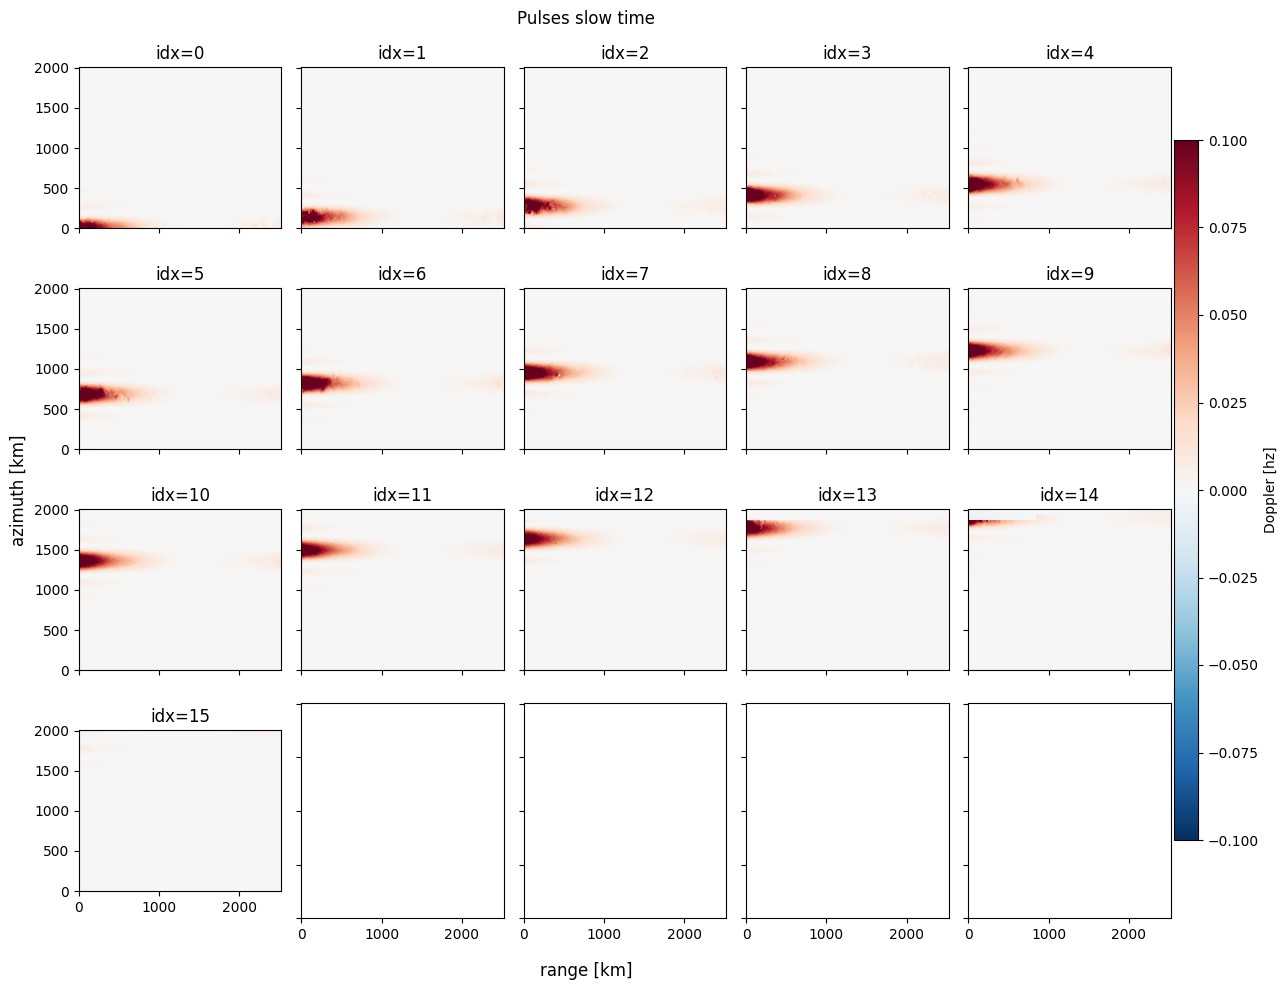

In [34]:
N = len(data.x_sat.time_slow)
columns = 5
rows = int(np.ceil(N / columns))
cbar_lim = 0.1

fig, axes = plt.subplots(rows, columns, figsize=(12, 10), sharex=True, sharey=True)

for t in range(N):
    # Extract the data for the current 't' coordinate
    data_sub = data.isel(time_slow=t).dop_beam_nrcs_weighted.values

    # Create a subplot in the specified grid position
    ax = axes[t // (rows + 1), t % columns]

    # Plot the data in the subplot
    im = ax.imshow(data_sub, cmap='RdBu_r', origin = 'lower', vmin=-cbar_lim, vmax =cbar_lim)
    ax.set_title(f'idx={t}')  # Set the title for the subplot
    
fig.suptitle('Pulses slow time')
fig.supxlabel('range [km]')
fig.supylabel('azimuth [km]')
plt.tight_layout()
cbar_ax = fig.add_axes([0.99, 0.15, 0.02, 0.7])
cbar = plt.colorbar(im, cax=cbar_ax)
cbar.set_label('Doppler [hz]')
plt.show()


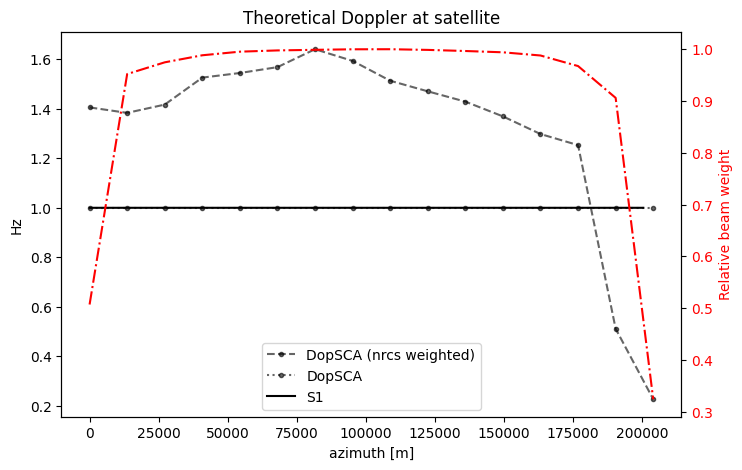

In [35]:
fig, ax = plt.subplots(figsize = (8, 5))
beam_weight = data['beam'].sum(dim = ['az', 'grg'])
D_weighted_beam_nrcs = data['dop_beam_nrcs_weighted'].sum(dim=['az', 'grg']).values/beam_weight
D_weighted_beam = data['dop_beam'].sum(dim=['az', 'grg']).values/beam_weight

ax.plot(x, D_weighted_beam_nrcs, '--', marker = '.', c = 'k', alpha = 0.6, label='DopSCA (nrcs weighted)',)
ax.plot(x, D_weighted_beam, ':', c = 'k', marker = '.', alpha = 0.6,label='DopSCA',)
ax.plot(data.az, data.dop.mean(dim=['grg']).values, label='S1', c = 'k')
ax.set_title('Theoretical Doppler at satellite')
ax.set_ylabel('Hz')
ax.set_xlabel('azimuth [m]')

ax2 = ax.twinx()
ax2.plot(x, beam_weight/beam_weight.max(), '-.', c = 'r', label = '')
ax2.set_ylabel('Relative beam weight', color = 'red') 
ax2.tick_params(axis ='y', labelcolor = 'red')
ax.legend(loc = 'lower center')